In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [79]:
#Load Data
data = pd.read_csv('train.csv')

In [81]:
#feature engineering
data = data.assign(
    AgeOfHouse = 2024 - data['YearBuilt'],
    TotalSF = data['GrLivArea'] + data['TotalBsmtSF']
)

In [83]:
#Handle Missing Values
data = data.fillna({
    'LotFrontage': data['LotFrontage'].median(),
    'MasVnrArea': 0
})

In [85]:
#Select key features
features = ['LotArea', 'OverallQual', 'AgeOfHouse', 'TotalSF', 'FullBath', 'GarageCars']
X = data[features]
y = np.log(data['SalePrice'])

In [87]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [89]:
# Normalize features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [91]:
# Reshape for CNN (samples, timesteps, features)
X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

In [93]:
#CNN Model Architecture
model = Sequential([
    InputLayer(shape=(X_train_cnn.shape[1], 1)),
    Conv1D(32, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1)
])

In [99]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 4, 32)          │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,449 (33.00 KB)

 Trainable params: 8,449 (33.00 KB)

 Non-trainable params: 0 (0.00 B)

In [121]:
# Train the model
history = model.fit(
    X_train_cnn, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_cnn, y_test),
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
    verbose=1
)

Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3385 - mae: 1.2173 - val_loss: 0.0354 - val_mae: 0.1454
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2330 - mae: 1.2075 - val_loss: 0.0432 - val_mae: 0.1691
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3590 - mae: 1.2301 - val_loss: 0.1019 - val_mae: 0.2882
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2214 - mae: 1.2049 - val_loss: 0.0303 - val_mae: 0.1280
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2683 - mae: 1.2050 - val_loss: 0.1489 - val_mae: 0.3578
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3124 - mae: 1.2063 - val_loss: 0.0821 - val_mae: 0.2530
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2585 - mae: 1.1680 - val_loss: 0.0753 - val_mae: 0.2390
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.1506 - mae: 1.1566 - val_loss: 0.0713 - val_mae: 0.2307
Epoch 9/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.068

In [123]:
# Evaluate
y_pred = model.predict(X_test_cnn).flatten()
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"\nTest RMSE (log scale): {rmse:.4f}")
print(f"Test RMSE (original scale): ${np.exp(rmse):,.2f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Test RMSE (log scale): 0.1739
Test RMSE (original scale): $1.19


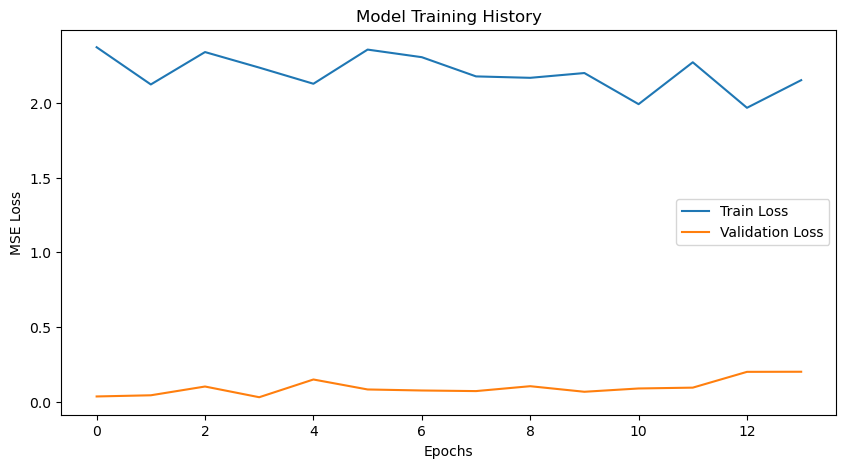

In [125]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

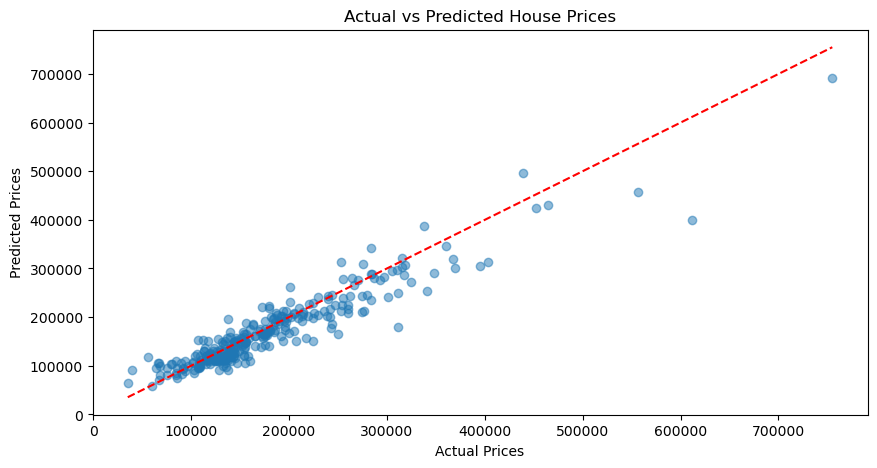

In [127]:
plt.figure(figsize=(10, 5))
plt.scatter(np.exp(y_test), np.exp(y_pred), alpha=0.5)
plt.plot([min(np.exp(y_test)), max(np.exp(y_test))], 
         [min(np.exp(y_test)), max(np.exp(y_test))], 'r--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted House Prices')
plt.show()

In [148]:
# Generate predictions
y_pred = model.predict(X_test_cnn).flatten()

# Convert from log scale back to original price scale
actual_prices = np.exp(y_test)
predicted_prices = np.exp(y_pred)

# Create comparison DataFrame
results_df = pd.DataFrame({
    'Actual Price': actual_prices,
    'Predicted Price': predicted_prices,
    'Absolute Error': np.abs(actual_prices - predicted_prices),
    'Percentage Error': (np.abs(actual_prices - predicted_prices) / actual_prices * 100)
})

# Display first 10 comparisons
print("Sample Price Predictions:")
print(results_df.head(10).round(2))

# Calculate overall metrics
mae = np.mean(results_df['Absolute Error'])
mape = np.mean(results_df['Percentage Error'])
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
r2 = r2_score(actual_prices, predicted_prices)


print(f"\nOverall Performance Metrics:")
print(f"MAE(Mean Absolute Error): ${mae:,.2f}")
print(f"RMSE(Root Mean Squared Error): ${rmse:,.2f}")
print(f"MAPE(Mean Absolute Precentage Error): {mape:.2f}%")
print(f"R² Score: {r2:.4f}")


# Visualization
plt.figure(figsize=(12, 6))

# Scatter plot of actual vs predicted
plt.subplot(1, 2, 1)
plt.scatter(actual_prices, predicted_prices, alpha=0.5)
plt.plot([actual_prices.min(), actual_prices.max()], 
         [actual_prices.min(), actual_prices.max()], 'r--')
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.title('Actual vs Predicted Prices')

# Error distribution
plt.subplot(1, 2, 2)
plt.hist(results_df['Percentage Error'], bins=30)
plt.xlabel('Percentage Error (%)')
plt.ylabel('Frequency')
plt.title('Prediction Error Distribution')

plt.tight_layout()
plt.show()



10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Sample Price Predictions:
      Actual Price  Predicted Price  Absolute Error  Percentage Error
892       154500.0    133517.218750        20982.78             13.58
1105      325000.0    272560.656250        52439.34             16.14
413       115000.0    119835.046875         4835.05              4.20
522       159000.0    157125.156250         1874.84              1.18
1036      315500.0    321947.312500         6447.31              2.04
614        75500.0     81366.796875         5866.80              7.77
218       311500.0    180292.187500       131207.83             42.12
1160      146000.0    157447.812500        11447.81              7.84
649        84500.0     81149.359375         3350.64              3.97
887       135500.0    119058.843750        16441.16             12.13


NameError: name 'r2_score' is not defined